In [1]:
t_end = 'Now'
duration_in_day = 30

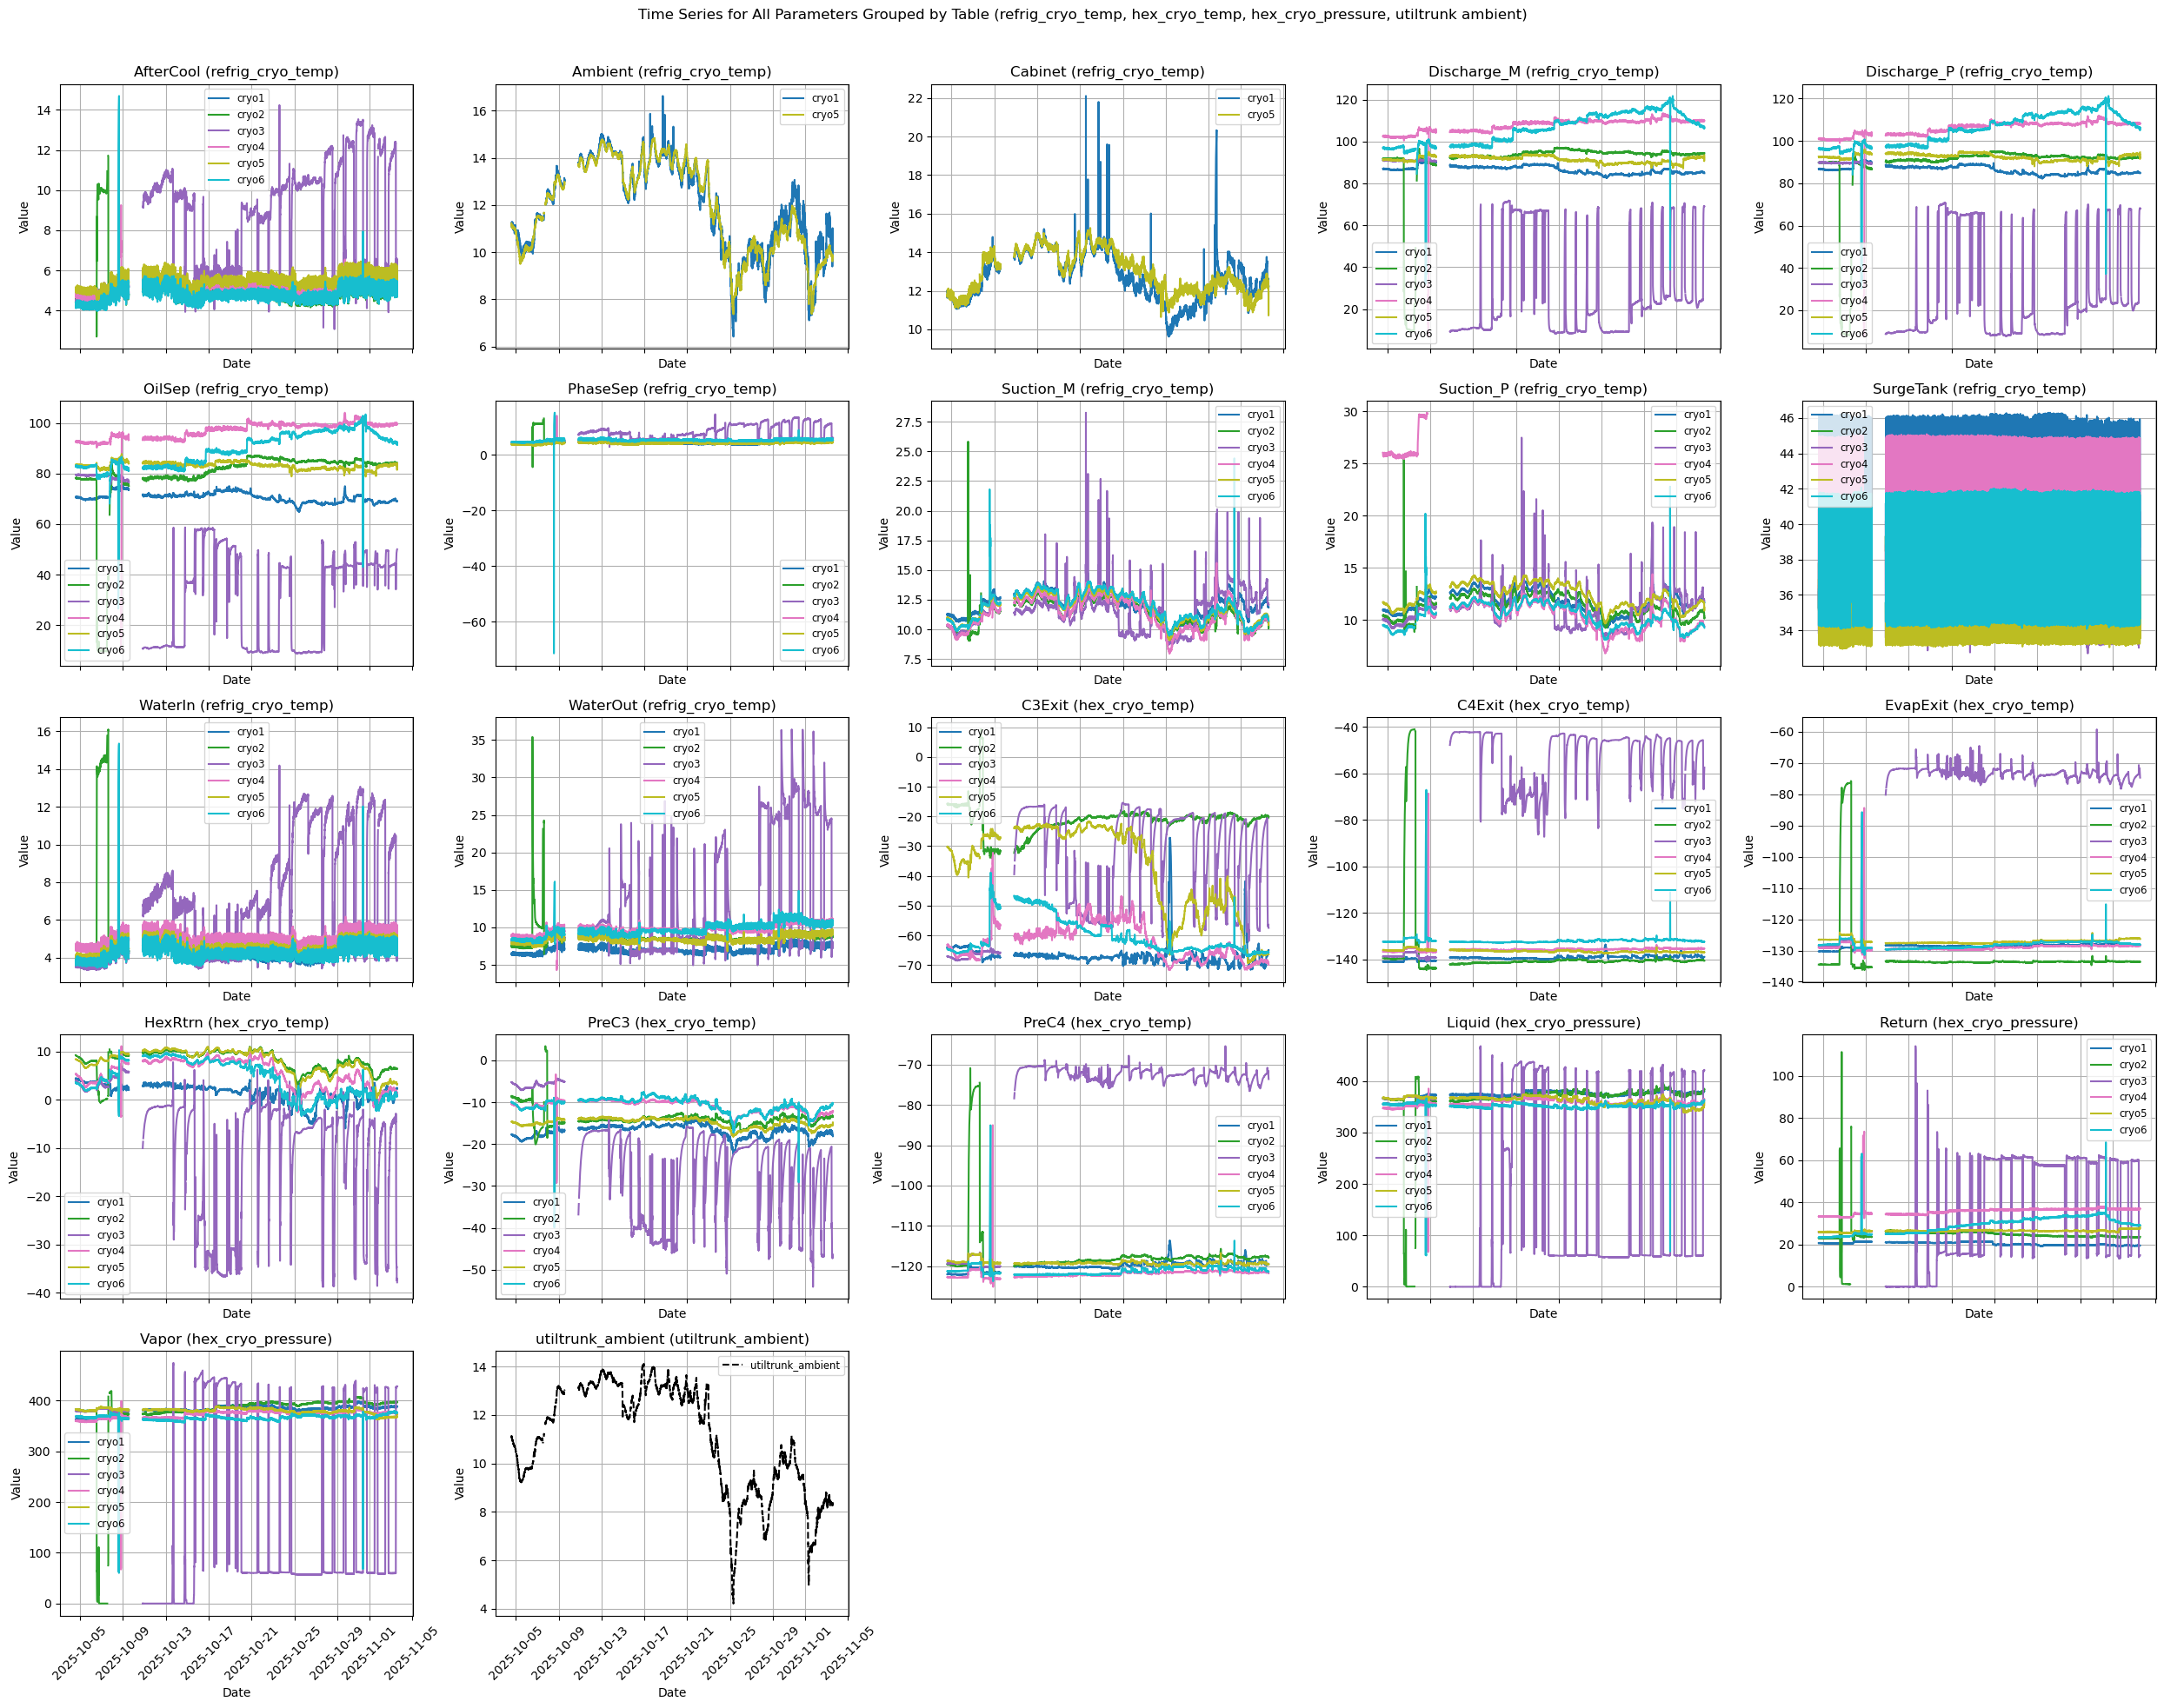

In [5]:
# Plot all sources grouped by table: refrig_cryo_temp, hex_cryo_temp, hex_cryo_pressure, utiltrunk ambient
from lsst_efd_client import EfdClient
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import numpy as np
import pandas as pd

client = EfdClient("usdf_efd")

# Prepare time range
if t_end == 'Now':
    t_end_val = Time.now()
else:
    t_end_val = Time(t_end)
t_start_val = t_end_val - TimeDelta(duration_in_day, format='jd')
t_start = t_start_val.iso
t_end = t_end_val.iso

def tidy_result(result):
    dfs = []
    if isinstance(result, dict):
        items = result.values()
    elif isinstance(result, list):
        items = result
    else:
        items = []
    for df in items:
        if df is None or df.empty:
            continue
        source_name = df['Source'].iloc[0] if 'Source' in df.columns and len(df['Source']) > 0 else None
        if 'mean' in df.columns:
            df = df.rename(columns={'mean': 'value'})
        if 'Source' in df.columns:
            df = df.drop(columns=['Source'])
        if source_name and 'value' in df.columns:
            df = df.rename(columns={'value': source_name})
        dfs.append(df)
    return dfs

# Collect sources by table for all cryo units
sources_by_table = {'refrig_cryo_temp': set(), 'hex_cryo_temp': set(), 'hex_cryo_pressure': set()}
cryo_data = {}
for i in range(6):
    cryo = f'cryo{i+1}'
    # refrig_cryo_temp
    refrig_query = f'''
    SELECT mean("temperature")
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo_temp"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Cryo"='{cryo}' 
      AND "Agent"='refrig2'
    GROUP BY time(5m), "Source" FILL(null)
    '''
    refrig_result = await client.influx_client.query(refrig_query)
    refrig_dfs = tidy_result(refrig_result)
    df_refrig = pd.concat(refrig_dfs, axis=1) if refrig_dfs else pd.DataFrame()
    sources_by_table['refrig_cryo_temp'].update(df_refrig.columns.tolist())
    # hex_cryo_temp
    hex_query = f'''
    SELECT mean("temperature")
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_temp"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Cryo"='{cryo}' 
    GROUP BY time(5m), "Source" FILL(null)
    '''
    hex_result = await client.influx_client.query(hex_query)
    hex_dfs = tidy_result(hex_result)
    df_hex = pd.concat(hex_dfs, axis=1) if hex_dfs else pd.DataFrame()
    sources_by_table['hex_cryo_temp'].update(df_hex.columns.tolist())
    # hex_cryo_pressure
    pressure_query = f'''
    SELECT mean("pressure")
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_pressure"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Cryo"='{cryo}' 
    GROUP BY time(5m), "Source" FILL(null)
    '''
    pressure_result = await client.influx_client.query(pressure_query)
    pressure_dfs = tidy_result(pressure_result)
    df_pressure = pd.concat(pressure_dfs, axis=1) if pressure_dfs else pd.DataFrame()
    sources_by_table['hex_cryo_pressure'].update(df_pressure.columns.tolist())
    # merge all
    df_all = pd.concat([df_refrig, df_hex, df_pressure], axis=1)
    cryo_data[cryo] = df_all

# utiltrunk ambient (outside air temperature)
utiltrunk_query = f'''
SELECT mean("AmbAirtemp") AS "utiltrunk_ambient"
FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.utiltrunk_body"
WHERE time > '{t_start}' AND time < '{t_end}'
  AND "Agent"='utiltrunk'
GROUP BY time(5m) FILL(null)
'''
utiltrunk_result = await client.influx_client.query(utiltrunk_query)
if isinstance(utiltrunk_result, pd.DataFrame):
    utiltrunk_ambient = utiltrunk_result['utiltrunk_ambient'] if 'utiltrunk_ambient' in utiltrunk_result.columns else None
    utiltrunk_dates = pd.to_datetime(utiltrunk_result.index) if utiltrunk_ambient is not None else None
else:
    utiltrunk_ambient = None
    utiltrunk_dates = None

# Prepare grouped sources list
grouped_sources = []
for tbl in ['refrig_cryo_temp', 'hex_cryo_temp', 'hex_cryo_pressure']:
    tbl_sources = sorted(list(sources_by_table[tbl]))
    grouped_sources.extend([(tbl, s) for s in tbl_sources])
if utiltrunk_ambient is not None:
    grouped_sources.append(('utiltrunk_ambient', 'utiltrunk_ambient'))

n_sources = len(grouped_sources)
ncols = 5
nrows = int(np.ceil(n_sources / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True)
axes = axes.flatten()
cryo_colors = plt.cm.tab10(np.linspace(0,1,6))

for idx, (tbl, source) in enumerate(grouped_sources):
    ax = axes[idx]
    plotted = False
    for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
        if cryo in cryo_data and source in cryo_data[cryo].columns:
            dates = pd.to_datetime(cryo_data[cryo].index)
            ax.plot(dates, cryo_data[cryo][source], label=cryo, color=cryo_colors[i])
            plotted = True
    if tbl == 'utiltrunk_ambient' and utiltrunk_ambient is not None:
        ax.plot(utiltrunk_dates, utiltrunk_ambient, label='utiltrunk_ambient', color='black', linestyle='--')
        plotted = True
    if plotted:
        ax.set_title(f'{source} ({tbl})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(loc='best', fontsize='small')
    else:
        ax.set_title(f'{source} ({tbl}) (no data)')
        ax.axis('off')
for idx in range(n_sources, len(axes)):
    axes[idx].axis('off')
plt.suptitle('Time Series for All Parameters Grouped by Table (refrig_cryo_temp, hex_cryo_temp, hex_cryo_pressure, utiltrunk ambient)')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
